In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [4]:
filename = '../../data/processed/feature-eng-clustered.csv'
df = pd.read_csv(filename)
df.head()

,zipcode,start_year,avg_eqi_year_5-10,year_1_EQI_MSA,year_1_EQI_state,year_1_EQI_zip,year_1_RECPI_MSA,year_1_RECPI_state,year_1_RECPI_zip,year_2_EQI_MSA,...,recpi_state_change_2,recpi_state_change_3,recpi_state_change_4,avg_eqi_year_1-5,dataset_cluster,zip_cluster,msa_cluster,state_cluster,eqi_cluster,recpi_cluster
0,1001,1992,0.001287,0.001549,0.002111,0.002216,1.176876,28.052156,0.048744,0.001266,...,1.020560,1.036390,1.251689,0.002170,3,0,0,1,0,0
1,1001,1997,0.001853,0.001233,0.002386,0.000840,1.112023,41.174500,0.035283,0.001164,...,1.245044,1.448812,0.693670,0.001287,3,0,0,1,0,0
2,1001,2002,0.000602,0.001494,0.002450,0.001504,1.746593,50.713380,0.054131,0.001073,...,0.905151,1.007785,1.046863,0.001853,3,0,0,1,0,0
3,1001,2007,0.000898,0.000702,0.001817,0.000611,1.081845,45.171143,0.036063,0.000758,...,0.801518,1.088810,1.051707,0.000602,3,0,0,1,0,0
4,1002,1992,0.002931,0.001549,0.002111,0.000959,1.176876,28.052156,0.020148,0.001266,...,1.020560,1.036390,1.251689,0.003141,3,1,0,1,0,0


In [5]:
X = df['zipcode'].unique()
y = df['zipcode'].unique()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X = df.drop('avg_eqi_year_5-10', axis=1)
y = df[['zipcode','start_year','avg_eqi_year_5-10']]

In [8]:
X_train = pd.DataFrame(X_train)
X_train.columns = ['zipcode']

X_test = pd.DataFrame(X_test)
X_test.columns = ['zipcode']

y_train = pd.DataFrame(y_train)
y_train.columns = ['zipcode']

y_test = pd.DataFrame(y_test)
y_test.columns = ['zipcode']

In [9]:
X_train = X_train.merge(X, on='zipcode').sort_values(['zipcode','start_year'], ignore_index=True)
X_test = X_test.merge(X, on='zipcode').sort_values(['zipcode','start_year'], ignore_index=True)
y_train = y_train.merge(y, on='zipcode').sort_values(['zipcode','start_year'], ignore_index=True)
y_test = y_test.merge(y, on='zipcode').sort_values(['zipcode','start_year'], ignore_index=True)

In [10]:
X_test = X_test.drop(['zipcode','start_year'], axis=1)
X_train = X_train.drop(['zipcode','start_year'], axis=1)
y_test = y_test[['avg_eqi_year_5-10']].to_numpy().ravel()
y_train = y_train[['avg_eqi_year_5-10']].to_numpy().ravel()

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import r2_score, mean_gamma_deviance, mean_absolute_error

In [12]:
column_trans = ColumnTransformer([
    ('scale', StandardScaler(), make_column_selector(dtype_include=np.float64)),
    ('dataset_cluster', OneHotEncoder(dtype='int'), ['dataset_cluster']),
    ('zip_cluster', OneHotEncoder(dtype='int'), ['zip_cluster']),
    ('msa_cluster', OneHotEncoder(dtype='int'), ['msa_cluster']),
    ('state_cluster', OneHotEncoder(dtype='int'), ['state_cluster']),
    ('eqi_cluster', OneHotEncoder(dtype='int'), ['eqi_cluster']),
    ('recpi_cluster', OneHotEncoder(dtype='int'), ['recpi_cluster'])
    ], remainder='drop')

column_trans.fit(X_train)

ColumnTransformer(transformers=[('scale', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000017AF6E65DC0>),
                                ('dataset_cluster', OneHotEncoder(dtype='int'),
                                 ['dataset_cluster']),
                                ('zip_cluster', OneHotEncoder(dtype='int'),
                                 ['zip_cluster']),
                                ('msa_cluster', OneHotEncoder(dtype='int'),
                                 ['msa_cluster']),
                                ('state_cluster', OneHotEncoder(dtype='int'),
                                 ['state_cluster']),
                                ('eqi_cluster', OneHotEncoder(dtype='int'),
                                 ['eqi_cluster']),
                                ('recpi_cluster', OneHotEncoder(dtype='int'),
                                 ['recpi_cluster'])])

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [14]:
rf = RandomForestRegressor(bootstrap=False, max_depth=72, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, n_estimators=315)

In [15]:
pipe = Pipeline([('transformer', column_trans), ('rf', rf)])

In [16]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000017AF6E65DC0>),
                                                 ('dataset_cluster',
                                                  OneHotEncoder(dtype='int'),
                                                  ['dataset_cluster']),
                                                 ('zip_cluster',
                                                  OneHotEncoder(dtype='int'),
                                                  ['zip_cluster']),
                                                 ('msa_cluster',
                                                  OneHotEncoder(dtype='int'),
                                                  ['msa_cluster']),
                                                 ('state_cluster',
                                           

In [17]:
y_pred = pipe.predict(X_test)

In [18]:
r2_score(y_test, y_pred)

0.604071867288065

In [19]:
y_comp = pd.DataFrame(y_test)
y_comp = y_comp.rename(columns={0: "Target"})

In [20]:
y_comp['Prediction'] = y_pred

In [21]:
y_comp['Diff'] = y_comp['Prediction'] - y_comp['Target']

In [162]:
y_comp['PE'] = (y_comp['Diff'] / y_comp['Target'])

In [163]:
y_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13628 entries, 0 to 13627
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Target      13628 non-null  float64 
 1   Prediction  13628 non-null  float64 
 2   Diff        13628 non-null  float64 
 3   Bin         13628 non-null  category
 4   PE          13628 non-null  float64 
dtypes: category(1), float64(4)
memory usage: 439.5 KB


In [104]:
bin_labels = [1, 2, 3, 4]
y_comp['Bin'] = pd.qcut(y_comp['Target'], q=4, labels=bin_labels)

In [105]:
y_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13628 entries, 0 to 13627
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Target      13628 non-null  float64 
 1   Prediction  13628 non-null  float64 
 2   Diff        13628 non-null  float64 
 3   Bin         13628 non-null  category
 4   PE          13628 non-null  float64 
dtypes: category(1), float64(4)
memory usage: 439.5 KB


In [106]:
quartile_metrics = pd.DataFrame()

In [107]:
quartile_metrics['q'] = [1, 2, 3, 4]

In [108]:
quartile_metrics

,q
0,1
1,2
2,3
3,4


### R-squared

In [109]:
quartile_metrics.at[0,'r2_score'] = r2_score(y_comp[y_comp['Bin']==1]['Target'], y_comp[y_comp['Bin']==1]['Prediction'])

In [110]:
quartile_metrics.at[1, 'r2_score'] = r2_score(y_comp[y_comp['Bin']==2]['Target'], y_comp[y_comp['Bin']==2]['Prediction'])

In [111]:
quartile_metrics.at[2, 'r2_score'] = r2_score(y_comp[y_comp['Bin']==3]['Target'], y_comp[y_comp['Bin']==3]['Prediction'])

In [112]:
quartile_metrics.at[3, 'r2_score'] = r2_score(y_comp[y_comp['Bin']==4]['Target'], y_comp[y_comp['Bin']==4]['Prediction'])

### Mean Absolute Error

In [113]:
quartile_metrics.at[0, 'mae'] = mean_absolute_error(y_comp[y_comp['Bin']==1]['Target'], y_comp[y_comp['Bin']==1]['Prediction'])

In [114]:
quartile_metrics.at[1, 'mae'] = mean_absolute_error(y_comp[y_comp['Bin']==2]['Target'], y_comp[y_comp['Bin']==2]['Prediction'])

In [115]:
quartile_metrics.at[2,'mae'] = mean_absolute_error(y_comp[y_comp['Bin']==3]['Target'], y_comp[y_comp['Bin']==3]['Prediction'])

In [116]:
quartile_metrics.at[3, 'mae'] = mean_absolute_error(y_comp[y_comp['Bin']==4]['Target'], y_comp[y_comp['Bin']==4]['Prediction'])

In [117]:
quartile_metrics

,q,r2_score,mae
0,1,-5.872517,0.000051
1,2,-12.822763,0.000056
2,3,-12.465260,0.000076
3,4,0.531189,0.000400


### Mean Percentage Error

In [118]:
quartile_metrics.at[0, 'mean'] = y_comp[y_comp['Bin']==1]['Target'].mean()

In [119]:
quartile_metrics.at[1, 'mean'] = y_comp[y_comp['Bin']==2]['Target'].mean()

In [120]:
quartile_metrics.at[2, 'mean'] = y_comp[y_comp['Bin']==3]['Target'].mean()

In [121]:
quartile_metrics.at[3, 'mean'] = y_comp[y_comp['Bin']==4]['Target'].mean()

In [122]:
quartile_metrics['mpe'] = quartile_metrics.apply(lambda row: (row['mae'] / row['mean']) * 100, axis=1)

In [123]:
sign = (y_comp[y_comp['Bin']==1]['Prediction'].mean() - y_comp[y_comp['Bin']==1]['Target'].mean()) / abs(y_comp[y_comp['Bin']==1]['Prediction'].mean() - y_comp[y_comp['Bin']==1]['Target'].mean())
quartile_metrics.at[0, 'mpe'] = quartile_metrics.at[0, 'mpe'] * sign

In [124]:
sign = (y_comp[y_comp['Bin']==2]['Prediction'].mean() - y_comp[y_comp['Bin']==2]['Target'].mean()) / abs(y_comp[y_comp['Bin']==2]['Prediction'].mean() - y_comp[y_comp['Bin']==2]['Target'].mean())
quartile_metrics.at[1, 'mpe'] = quartile_metrics.at[1, 'mpe'] * sign

In [125]:
sign = (y_comp[y_comp['Bin']==3]['Prediction'].mean() - y_comp[y_comp['Bin']==3]['Target'].mean()) / abs(y_comp[y_comp['Bin']==3]['Prediction'].mean() - y_comp[y_comp['Bin']==3]['Target'].mean())
quartile_metrics.at[2, 'mpe'] = quartile_metrics.at[2, 'mpe'] * sign

In [126]:
sign = (y_comp[y_comp['Bin']==4]['Prediction'].mean() - y_comp[y_comp['Bin']==4]['Target'].mean()) / abs(y_comp[y_comp['Bin']==4]['Prediction'].mean() - y_comp[y_comp['Bin']==4]['Target'].mean())
quartile_metrics.at[3, 'mpe'] = quartile_metrics.at[3, 'mpe'] * sign

In [127]:
quartile_metrics

,q,r2_score,mae,mean,mpe
0,1,-5.872517,0.000051,0.000136,37.318446
1,2,-12.822763,0.000056,0.000228,24.435122
2,3,-12.465260,0.000076,0.000338,22.472328
3,4,0.531189,0.000400,0.001087,-36.835352


## Visualization

In [153]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

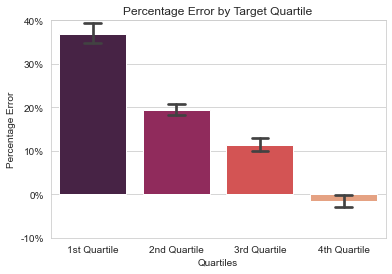

In [249]:
sns.set_style("whitegrid")
fig = sns.barplot(x=y_comp['Bin'], y=y_comp['PE'], capsize=.2,  palette="rocket")
plt.ylim(-.10, .40)
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xticks(np.arange(4), ('1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile'))
plt.xlabel('Quartiles')
plt.ylabel('Percentage Error')
plt.title('Percentage Error by Target Quartile')
plt.savefig('../../reports/figures/PE_quartiles')

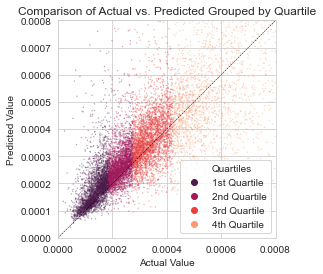

In [286]:
fig = sns.scatterplot(data=y_comp, x='Target', y='Prediction', s=2, palette="rocket", hue='Bin', edgecolor='None', alpha=0.4)

# replace labels
new_labels = ['Quartiles','1st Quartile', '2nd Quartile', '3rd Quartile', '4th Quartile']
for t, l in zip(fig.legend().texts, new_labels): t.set_text(l)

fig.set_aspect('equal', adjustable='box')
X_plot = np.linspace(0, 0.001, 100)
y_plot = np.linspace(0, 0.001, 100)
plt.plot(X_plot, y_plot, ls="--", c='black', linewidth=0.5)
plt.xlim(0, 0.0008)
plt.ylim(0, 0.0008)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Comparison of Actual vs. Predicted Grouped by Quartile')
plt.savefig('../../reports/figures/actual_vs_predicted')